Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Define Hyperparameters

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.2
THRESHOLD = 0.95

Fetch and preprocess MNIST data

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

labeled_index = np.random.choice(x_train.shape[0], int(x_train.shape[0] * 0.1), replace=False)
labeled_mask = np.zeros(len(x_train), dtype=bool)
labeled_mask[labeled_index] = 1
labeled_x_train, labeled_y_train = x_train[labeled_mask], y_train[labeled_mask]
unlabeled_x_train, unlabeled_y_train = x_train[~labeled_mask], y_train[~labeled_mask]

print("Number of labeled training examples:", len(labeled_x_train))
print("Number of unlabeled training examples:", len(unlabeled_x_train))

Number of original training examples: 60000
Number of original test examples: 10000
Number of labeled training examples: 6000
Number of unlabeled training examples: 54000


Define model

In [22]:
supervised_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32,activation='relu'),
  tf.keras.layers.Dense(10,activation='softmax')
])

supervised_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

semi_supervised_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32,activation='relu'),
  tf.keras.layers.Dense(10,activation='softmax')
])

semi_supervised_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

semi_supervised_model.save_weights("./init")

Supervised (Baseline)

In [23]:
best_loss = 1000
for epoch in range(EPOCHS):
  history = supervised_model.fit(labeled_x_train, labeled_y_train, validation_split=VALIDATION_SPLIT)
  loss = history.history['val_loss'][0]
  if loss < best_loss:
    supervised_model.save_weights("./checkpoint")
    print("Saving checkpoint")
    best_loss = loss
supervised_model.load_weights("./checkpoint")
hist = supervised_model.evaluate(x_test, y_test)
supervised_loss, supervised_accuracy = hist[0], hist[1]

150/150 [==============================] - 1s 4ms/step - loss: 1.3851 - sparse_categorical_accuracy: 0.5530 - val_loss: 0.2737 - val_sparse_categorical_accuracy: 0.9050
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9454 - val_loss: 0.1417 - val_sparse_categorical_accuracy: 0.9617
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9575 - val_loss: 0.1300 - val_sparse_categorical_accuracy: 0.9633
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.0997 - val_sparse_categorical_accuracy: 0.9692
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0943 - val_sparse_categorical_accuracy: 0.9733
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.

Semi-Supervised

In [6]:
semi_supervised_loss = []
semi_supervised_accuracy = []
while True:
  print(len(labeled_x_train))
  best_loss = 1000
  semi_supervised_model.load_weights("./init")
  shuffler = np.random.permutation(len(labeled_y_train))
  labeled_x_train, labeled_y_train = labeled_x_train[shuffler], labeled_y_train[shuffler]
  for epoch in range(EPOCHS):
    semi_supervised_model.evaluate(x_test,y_test)
    history = semi_supervised_model.fit(labeled_x_train, labeled_y_train, validation_split=VALIDATION_SPLIT)
    loss = history.history['val_loss'][0]
    if loss < best_loss:
      semi_supervised_model.save_weights("./checkpoint")
      print("Saving checkpoint")
      best_loss = loss
  semi_supervised_model.load_weights("./checkpoint")
  prediction = semi_supervised_model.predict(unlabeled_x_train)
  mask = np.amax(prediction, axis=1) > THRESHOLD
  new_x_train, new_y_train = unlabeled_x_train[mask], np.argmax(prediction[mask], axis=1)
  # original_y_train = unlabeled_y_train[mask]
  # prediction = prediction[mask]
  # print("----")
  # print(np.sum(mask))
  # res = np.equal(new_y_train, original_y_train)
  # print(np.sum(res))
  # false_labeled_x, false_labeled_y, original_y = new_x_train[~res], new_y_train[~res], original_y_train[~res]
  # prediction = prediction[~res]
  # plt.figure(figsize=(10, 10))
  # for i in range(9):
  #   print(prediction[i])
  #   ax = plt.subplot(3, 3, i + 1)
  #   plt.imshow(tf.squeeze(false_labeled_x[i]))
  #   plt.title("should be {} but is {}".format(original_y[i], false_labeled_y[i]))
  #   plt.axis("off")
  # print("----")
  labeled_x_train, labeled_y_train = np.vstack((labeled_x_train, new_x_train)), np.concatenate((labeled_y_train, new_y_train))
  unlabeled_x_train = unlabeled_x_train[~mask]
  unlabeled_y_train = unlabeled_y_train[~mask]
  hist = semi_supervised_model.evaluate(x_test,y_test)
  semi_supervised_loss.append(hist[0])
  semi_supervised_accuracy.append(hist[1])
  if np.sum(mask) < 20:
    break


6000
150/150 [==============================] - 1s 4ms/step - loss: 0.7661 - sparse_categorical_accuracy: 0.7752 - val_loss: 0.3077 - val_sparse_categorical_accuracy: 0.9092
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.2127 - sparse_categorical_accuracy: 0.9340 - val_loss: 0.1833 - val_sparse_categorical_accuracy: 0.9458
Saving checkpoint
150/150 [==============================] - 1s 3ms/step - loss: 0.1436 - sparse_categorical_accuracy: 0.9542 - val_loss: 0.1493 - val_sparse_categorical_accuracy: 0.9575
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.1239 - val_sparse_categorical_accuracy: 0.9650
Saving checkpoint
150/150 [==============================] - 0s 3ms/step - loss: 0.0611 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.1220 - val_sparse_categorical_accuracy: 0.9667
Saving checkpoint
150/150 [==============================] - 1s 3ms/step - los

0.08834222704172134
[0.08803582936525345, 0.09048420190811157, 0.08983496576547623, 0.0775272399187088, 0.0705375149846077, 0.09518241882324219, 0.0768783763051033, 0.08942500501871109, 0.0755145326256752, 0.1069302037358284, 0.07206369936466217]
0.9743000268936157
[0.9740999937057495, 0.9797000288963318, 0.9800000190734863, 0.9812999963760376, 0.980400025844574, 0.9811000227928162, 0.9811999797821045, 0.9807999730110168, 0.9811999797821045, 0.9803000092506409, 0.978600025177002]


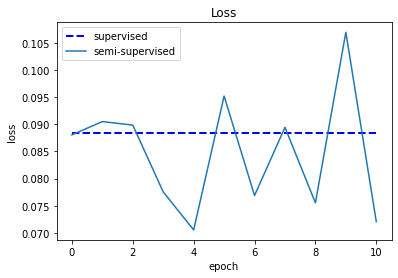

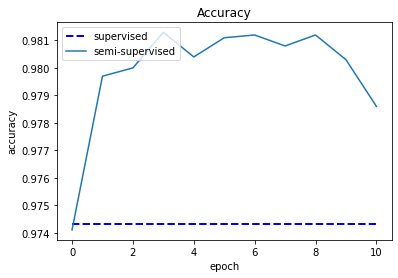

In [25]:
print(supervised_loss)
print(semi_supervised_loss)

print(supervised_accuracy)
print(semi_supervised_accuracy)

plt.plot([0, 10], [supervised_loss, supervised_loss], color='b', linestyle='--', linewidth=2)
plt.plot(semi_supervised_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["supervised", "semi-supervised"], loc='upper left')
plt.show()


plt.plot([0, 10], [supervised_accuracy, supervised_accuracy], color='b', linestyle='--', linewidth=2)
plt.plot(semi_supervised_accuracy)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["supervised", "semi-supervised"], loc='upper left')
plt.show()